In [1]:
using NBInclude
@nbinclude("functions.ipynb")

function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3
end

function load_model_v2(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder W
    println("Done")
    return encoder_μ, encoder_logvar, decoder, W
end

function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end
# function load_model_identity(load_dir::String, epoch::Int)
#     print("Loading model...")
#     @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder W3
#     println("Done")
#     return encoder_μ, encoder_logvar, decoder, W
# end
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST(split=:test)[:]
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

All function imported


get_test_loader (generic function with 1 method)

Loading model...Done


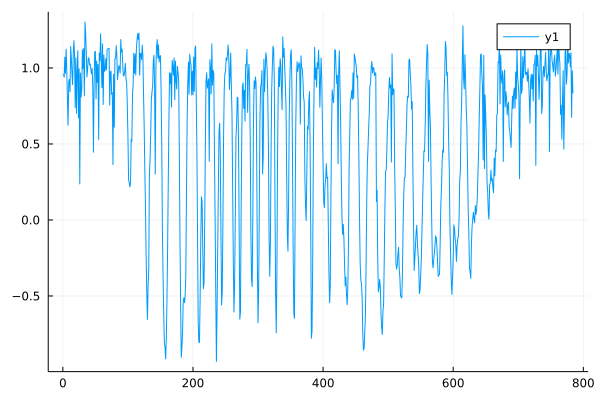

In [49]:
# Load the model and est set loar unenforced
epoch_to_load_co = 100
dir_co = "../trained_GNN/test/trained_GNN/MNIST_relu_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W= load_model_v2(dir_co, epoch_to_load_co);

#setup
x_dim = 784
k = 20
num = 2
batch_size = 6400
shuffle_data = true

dataloader = get_test_loader(batch_size, shuffle_data)
(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
i += 1
end
x_true= reshape(x_batch[:, i], 784,1)

# Apply reparameterisation trick to sample latent
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)

m = 50
F_sub = sample_fourier_with_1(m, x_dim)  # subsampling DCT for measurement matrix
F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

z_true = z_inco
G_inco(z) =  sigmoid( .2 .* (W*decoder_inco(z) .- 1 )) 
y = F_sub * G_inco(z_true)
# measurement vector using subsampled DCT matrix
plot(.2 .* (W*decoder_inco(z_true) .- 1 ))
# colorview(Gray, reshape(G_inco(z_true), 28, 28)' )
# # colorview(Gray, reshape(G_inco(randn(20)), 28, 28)' )



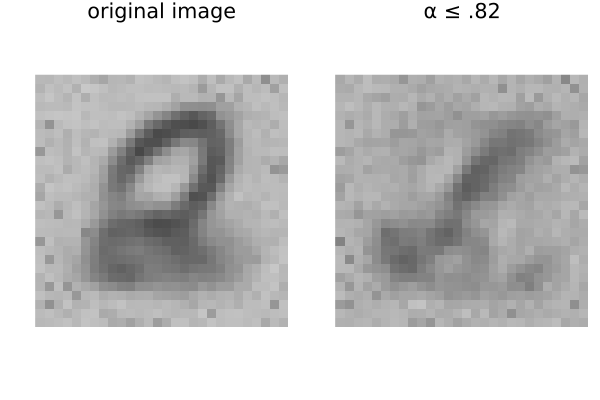

In [52]:
tolerance = 1e-14; max_iter = 5000; out_toggle = 0
opt = Flux.Optimise.ADAM(.01);
z_est = randn(k,1); #initialization for algorithm
z_est = estimated_code(opt, G_inco, y, F_sub, z_est; max_iter, tolerance, out_toggle);  # run a optimizer to solve the least squares problem
p1 = plot(colorview(Gray, reshape(G_inco(z_true), 28,28)' ), framestyle = :none, bg =:black, title = "original image")
p2 = plot(colorview(Gray, reshape(G_inco(z_est), 28,28)' ), framestyle = :none, bg =:black, title = "α ≤ .82")

plot(p1,p2)


In [4]:
k = 20
m_list = [10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 250];
batch_size = 64
shuffle_data = true


nums = 1:9

z_co_sig_list = zeros(length(nums), k)
z_inco_list = zeros(length(nums), k)

x_true_list = zeros(length(nums), 784)
z_est_inco_matrix = zeros(length(nums), k, length(m_list))
z_est_co_sig_matrix = zeros(length(nums), k, length(m_list))

Threads.@threads for num_index in 1:length(nums)
    num = nums[num_index]
    dataloader = get_test_loader(batch_size, shuffle_data)
    (x_batch, y_batch) = first(dataloader)
    i = 1
    while y_batch[i] != num
    i += 1
    end
    x_true= x_batch[:, i];

    z_est_inco_list = zeros(k, length(m_list))
    z_est_co_sig_list = zeros(k, length(m_list))

    x_true_list[num_index,:] = x_true

    # Apply reparameterisation trick to sample latent
    μ = encoder_μ_inco(x_true)
    logvar_inco = encoder_logvar_inco(x_true)
    z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)
    z_inco_list[num_index,:] = z_inco

    μ = encoder_μ_co_sig(x_true)
    logvar_co_sig = encoder_logvar_co_sig(x_true)
    # Apply reparameterisation trick to sample latent
    z_co_sig = μ + randn(Float32, size(logvar_co_sig)) .* exp.(0.5f0 * logvar_co_sig)
    z_co_sig_list[num_index,:] = z_co_sig

     for i in 1:length(m_list)
        m = m_list[i]
        F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

        y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
        z_est_inco = randn(k) #initialization for algorithm
        z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        z_est_inco_list[:,i] = z_est_inco

        y = F_sub * G_co_sig(z_co_sig) # measurement vector using subsampled DCT matrix
        z_est_co_sig = randn(k) #initialization for algorithm
        z_est_co_sig = estimated_code(opt, G_co_sig, y, F_sub, z_est_co_sig; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        z_est_co_sig_list[:,i] = z_est_co_sig
    end

    z_est_inco_matrix[num_index,:,:] = z_est_inco_list
    z_est_co_sig_matrix[num_index,:,:] = z_est_co_sig_list

end


In [6]:
save("../test/saved_data/MNIST_image_recovery_sigmoid.jld", "z_inco_list", z_inco_list, "z_co_sig_list", z_co_sig_list,"x_true_list", x_true_list, "z_est_inco_matrix", z_est_inco_matrix, "z_est_co_sig_matrix", z_est_co_sig_matrix, "m_list", m_list)

In [7]:
k = 20
m_list = [10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 250, 300, 400, 500, 600];
batch_size = 6400
shuffle_data = true

trials = 20
recon_error_matrix_inco = zeros(length(m_list), trials)
recon_error_matrix_co_sig = zeros(length(m_list), trials)


Threads.@threads for trials in 1:trials
    recon_error_list_inco = []
    recon_error_list_co_sig = []

    for m in m_list
        num = rand(1:9)
        dataloader = get_test_loader(batch_size, shuffle_data)
        (x_batch, y_batch) = first(dataloader)
        i = 1
        while y_batch[i] != num
            i += 1
        end
        x_true= x_batch[:, i];
    
        # Apply reparameterisation trick to sample latent
        μ = encoder_μ_inco(x_true)
        logvar_inco = encoder_logvar_inco(x_true)
        z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)
    

        μ = encoder_μ_co_sig(x_true)
        logvar_co = encoder_logvar_co_sig(x_true)
        # Apply reparameterisation trick to sample latent
        z_co_sig = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)

        F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

        y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
        z_est_inco = randn(k) #initialization for algorithm
        z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        push!(recon_error_list_inco, relative_error(G_inco(z_inco), G_inco(z_est_inco)))

        y = F_sub * G_co_sig(z_co_sig) # measurement vector using subsampled DCT matrix
        z_est_co_sig = randn(k) #initialization for algorithm
        z_est_co_sig = estimated_code(opt, G_co_sig, y, F_sub, z_est_co_sig; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        push!(recon_error_list_co_sig, relative_error(G_co_sig(z_co_sig), G_co_sig(z_est_co_sig)))

    end
    recon_error_matrix_inco[:, trials] = recon_error_list_inco
    recon_error_matrix_co_sig[:, trials] = recon_error_list_co_sig
end





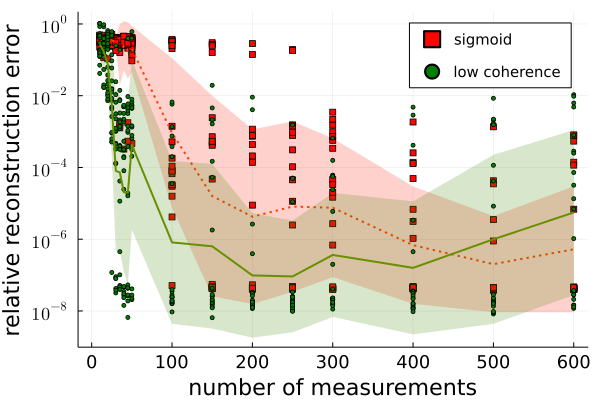

In [32]:

# log_recon_error_matrix_co = log10.(recon_error_matrix_co[:, :])
# average_recon_co = mean(log_recon_error_matrix_co, dims=2)
# std_recon_co = std(log_recon_error_matrix_co, dims=2)
# plot(m_list, average_recon_co + std_recon_co, fillrange = average_recon_co - std_recon_co, fillalpha = .2, c = cs[40], label = false, linecolor = invisible())
# scatter!(kron(m_list,ones(1,trials))[:], log_recon_error_matrix_co[:], label =:false, c = cs[100], markershape = :dtriangle, lab="high coherence", legendfontsize=10, markersize = 3)
# plot!(m_list, average_recon_co, linewidth = 2, color = cs[10], label =false, linestyle =:dash )
# yticks = [-8:2:0;]
# yticks!(yticks, [L"10^{%$y}" for y in yticks])

# scatter!([1],[0], label=" ", ms=0, mc=:white, msc=:white)

log_recon_error_matrix_co_sig = log10.(recon_error_matrix_co_sig[:, :])
average_recon_co_sig = mean(log_recon_error_matrix_co_sig, dims=2)
std_recon_co_sig = std(log_recon_error_matrix_co_sig, dims=2)
plot(m_list, average_recon_co_sig + std_recon_co_sig, fillrange = average_recon_co_sig - std_recon_co_sig, fillalpha = .2, c = cs[40], label = false, linecolor = invisible())
scatter!(kron(m_list,ones(1,trials))[:], log_recon_error_matrix_co_sig[:], label =:false, c = cs[10], markershape = :square, lab="sigmoid", legendfontsize=10, fillalpha = .2, markersize = 3)
plot!(m_list, average_recon_co_sig, linewidth = 2, color = cs[100], label =false, linestyle =:dot )
yticks = [-8:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])

scatter!([1],[0], label=" ", ms=0, mc=:white, msc=:white)


log_recon_error_matrix_inco = log10.(recon_error_matrix_inco[:, :])
average_recon_inco = mean(log_recon_error_matrix_inco, dims=2)
std_recon_inco = std(log_recon_error_matrix_inco, dims=2)
plot!(m_list, average_recon_inco + std_recon_inco, fillrange = average_recon_inco - std_recon_inco, fillalpha = .2, c = cs[440], label = false, linecolor = invisible())
scatter!(kron(m_list,ones(1,trials))[:], log_recon_error_matrix_inco[:], label =:false, c = cs[500], lab="low coherence", markersize = 3)
plot!(m_list, average_recon_inco, xlabel = "number of measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[400], label =false,  xlabelfontsize = 15, ylabelfontsize = 15, xtickfontsize = 12, ytickfontsize = 12 )

# savefig("figures/all_measurements_v3.pdf")

In [31]:
recon_error_matrix_co_sig

17×20 Matrix{Float64}:
 0.412418     0.424862     0.346965    …  0.434316     0.338026
 0.458954     0.348732     0.296096       0.114431     0.412606
 0.26764      0.404001     0.285512       0.417777     0.307806
 0.385965     0.367626     0.366366       0.395813     0.329507
 0.274626     0.215652     0.321251       0.348688     0.30184
 0.244586     0.280809     0.352187    …  0.367455     0.00126888
 0.000325488  0.304589     0.392812       0.458213     0.303953
 0.001767     0.314354     0.296241       0.265524     0.292274
 0.292442     0.000468788  0.408939       0.0942663    0.404623
 0.337182     3.22046e-5   1.58653e-5     0.00018179   0.248468
 0.000720409  0.300746     0.160038    …  0.246491     4.58301e-8
 4.44224e-8   4.23012e-8   8.91695e-6     4.31644e-8   0.000210104
 4.70771e-8   0.000104512  4.65219e-8     0.000955699  4.43187e-8
 0.000342519  0.000571127  1.48473e-5     0.00073154   4.7134e-8
 4.91683e-5   4.47941e-8   3.13278e-6     4.10429e-8   4.51615e-8
 3.974